In [1]:
versioninfo()

Julia Version 1.4.0
Commit b8e9a9ecc6 (2020-03-21 16:36 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin18.6.0)
  CPU: Intel(R) Core(TM) i5-8279U CPU @ 2.40GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-8.0.1 (ORCJIT, skylake)


In [2]:
using Pkg
Pkg.activate("../..")
Pkg.status()

 Activating environment at `~/Dropbox/class/M1399.000200/2020/Project.toml`


Status `~/Dropbox/class/M1399.000200/2020/Project.toml`
  [6e4b80f9] BenchmarkTools v0.5.0
  [31c24e10] Distributions v0.23.10
  [c91e804a] Gadfly v1.3.0
  [bd48cda9] GraphRecipes v0.5.4
  [47be7bcc] ORCA v0.5.0
  [a03496cd] PlotlyBase v0.4.1
  [f0f68f2c] PlotlyJS v0.14.0
  [91a5bcdd] Plots v1.6.1
  [438e738f] PyCall v1.91.4
  [d330b81b] PyPlot v2.9.0
  [6f49c342] RCall v0.13.7
  [2913bbd2] StatsBase v0.32.2
  [8f399da3] Libdl 
  [10745b16] Statistics 


# Conditioning of linear regression by least squares

* Recall that for nonsingular linear equation solve, i.e. $\mathbf{A}\mathbf{x} = \mathbf{b}$, the condition number  of the problem with $\mathbf{b}$ held fixed is equal to the condition number of matrix $\mathbf{A}$
$$
    \kappa(\mathbf{A}) = \|\mathbf{A}\|\|\mathbf{A}^{-1}\|.
$$

* If $\mathbf{A}$ is not square, then its condition number is
$$
    \kappa(\mathbf{A}) = \|\mathbf{A}\|\|\mathbf{A}^{\dagger}\|,
$$
where $\mathbf{A}^{\dagger}$ is Moore-Penrose pseudoinverse of $\mathbf{A}$.

* **Condition number for the least squares problem** $\mathbf{y} \approx \mathbf{X}\boldsymbol{\beta}$ is more complicated and depends on the residual. It can be shown that the condition number is
$$
    \kappa(\mathbf{X}) + \frac{\kappa(\mathbf{X})^2\tan\theta}{\eta},
$$
where

$$
    \theta = \cos^{-1}\frac{\|\mathbf{X}\boldsymbol{\beta}\|}{\|\boldsymbol{\beta}\|},
    \quad
    \eta = \frac{\|\mathbf{X}\|\|\boldsymbol{\beta}\|}{\|\mathbf{X}\boldsymbol{\beta}\|}
    .
$$

* So if $\kappa(\mathbf{X})$ is large ($\mathbf{X}$ is close to collinear), the condition number of the least squares problem is dominated by $\kappa(\mathbf{X})^2$, unless the residuals are small.
    - In this case, *stable* algorithm is preferred.

* This is because the problem is equivalent to the normal equation
$$
    \mathbf{X}^T\mathbf{X}\boldsymbol{\beta} = \mathbf{X}^T\mathbf{y}.
$$
    
* Consider the simple case
$$
\begin{eqnarray*}
	\mathbf{X} = \begin{bmatrix}
	1 & 1 \\
	10^{-3} & 0 \\
	0 & 10^{-3}
	\end{bmatrix}.
\end{eqnarray*}
$$
Forming normal equation yields a singular Gramian matrix
$$
\begin{eqnarray*}
	\mathbf{X}^T \mathbf{X} = \begin{bmatrix}
	1 & 1 \\
	1 & 1
	\end{bmatrix}
\end{eqnarray*}
$$
if executed with a precision of 6 decimal digits. This has the condition number $\kappa(\mathbf{X}^T\mathbf{X})=\infty$.

## Longley example

The [Longley (1967)](https://www.jstor.org/stable/2283673?seq=1#page_scan_tab_contents) macroeconomic [data set](https://www.itl.nist.gov/div898/strd/lls/data/Longley.shtml) is a famous test example for numerical software in early dates.

* [Link to download](./longley.txt)

In [3]:
using DelimitedFiles

longley = readdlm("longley.txt")

16×7 Array{Float64,2}:
 60323.0   83.0  234289.0  2356.0  1590.0  107608.0  1947.0
 61122.0   88.5  259426.0  2325.0  1456.0  108632.0  1948.0
 60171.0   88.2  258054.0  3682.0  1616.0  109773.0  1949.0
 61187.0   89.5  284599.0  3351.0  1650.0  110929.0  1950.0
 63221.0   96.2  328975.0  2099.0  3099.0  112075.0  1951.0
 63639.0   98.1  346999.0  1932.0  3594.0  113270.0  1952.0
 64989.0   99.0  365385.0  1870.0  3547.0  115094.0  1953.0
 63761.0  100.0  363112.0  3578.0  3350.0  116219.0  1954.0
 66019.0  101.2  397469.0  2904.0  3048.0  117388.0  1955.0
 67857.0  104.6  419180.0  2822.0  2857.0  118734.0  1956.0
 68169.0  108.4  442769.0  2936.0  2798.0  120445.0  1957.0
 66513.0  110.8  444546.0  4681.0  2637.0  121950.0  1958.0
 68655.0  112.6  482704.0  3813.0  2552.0  123366.0  1959.0
 69564.0  114.2  502601.0  3931.0  2514.0  125368.0  1960.0
 69331.0  115.7  518173.0  4806.0  2572.0  127852.0  1961.0
 70551.0  116.9  554894.0  4007.0  2827.0  130081.0  1962.0

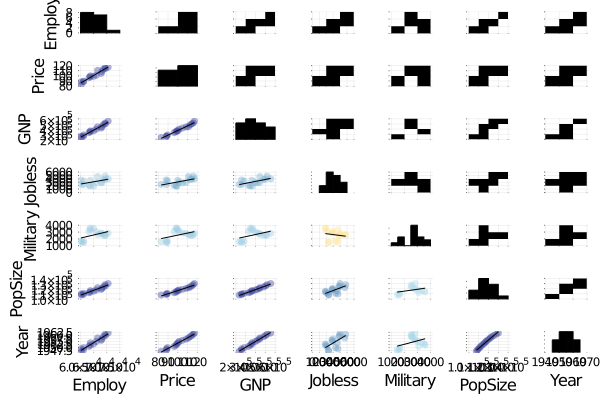

In [4]:
using StatsPlots
gr()

corrplot(longley, 
    label = ["Employ" "Price" "GNP" "Jobless" "Military" "PopSize" "Year"])

In [5]:
# response: Employment
y = longley[:, 1]
# predictor matrix
X = [ones(length(y)) longley[:, 2:end]]

16×7 Array{Float64,2}:
 1.0   83.0  234289.0  2356.0  1590.0  107608.0  1947.0
 1.0   88.5  259426.0  2325.0  1456.0  108632.0  1948.0
 1.0   88.2  258054.0  3682.0  1616.0  109773.0  1949.0
 1.0   89.5  284599.0  3351.0  1650.0  110929.0  1950.0
 1.0   96.2  328975.0  2099.0  3099.0  112075.0  1951.0
 1.0   98.1  346999.0  1932.0  3594.0  113270.0  1952.0
 1.0   99.0  365385.0  1870.0  3547.0  115094.0  1953.0
 1.0  100.0  363112.0  3578.0  3350.0  116219.0  1954.0
 1.0  101.2  397469.0  2904.0  3048.0  117388.0  1955.0
 1.0  104.6  419180.0  2822.0  2857.0  118734.0  1956.0
 1.0  108.4  442769.0  2936.0  2798.0  120445.0  1957.0
 1.0  110.8  444546.0  4681.0  2637.0  121950.0  1958.0
 1.0  112.6  482704.0  3813.0  2552.0  123366.0  1959.0
 1.0  114.2  502601.0  3931.0  2514.0  125368.0  1960.0
 1.0  115.7  518173.0  4806.0  2572.0  127852.0  1961.0
 1.0  116.9  554894.0  4007.0  2827.0  130081.0  1962.0

In [6]:
using LinearAlgebra

# Julia function for obtaining condition number
cond(X)

4.859257015454868e9

In [7]:
# we see the smallest singular value (aka trouble number) is very small
xsvals = svdvals(X)

7-element Array{Float64,1}:
     1.6636682278894703e6
 83899.57794622083
  3407.197376095864
  1582.6436810037958
    41.69360109707282
     3.6480937948061642
     0.00034237090621018257

In [8]:
# condition number of the design matrix
xcond = maximum(xsvals) / minimum(xsvals)

4.859257015454868e9

In [9]:
# X is full rank from SVD
xrksvd = rank(X)

7

In [10]:
# least squares from QR
X \ y

7-element Array{Float64,1}:
   -3.4822586345937266e6
   15.061872271247148
   -0.03581917929254092
   -2.020229803816271
   -1.0332268671735412
   -0.05110410565344539
 1829.1514646124697

In [11]:
# Gram matrix
G = X'X

7×7 Array{Float64,2}:
    16.0          1626.9        6.20318e6   …  1.87878e6  31272.0
  1626.9        167172.0        6.46701e8      1.9214e8       3.18054e6
     6.20318e6       6.46701e8  2.55315e12     7.3868e11      1.21312e10
 51093.0             5.28908e6  2.06505e10     6.06649e9      9.99059e7
 41707.0             4.29317e6  1.66329e10     4.92386e9      8.15371e7
     1.87878e6       1.9214e8   7.3868e11   …  2.2134e11      3.67258e9
 31272.0             3.18054e6  1.21312e10     3.67258e9      6.11215e7

In [12]:
# rank of Gram matrix from SVD
# rank deficient! We lost precision when forming Gram matrix
rank(G)

6

In [13]:
svdvals(G)

7-element Array{Float64,1}:
    2.7677919724888896e12
    7.039139179553959e9
    1.160899395967452e7
    2.5047610210212315e6
 1738.3563724374112
   13.308588281731947
    1.1609902991000544e-7

In [14]:
# rank of Gram matrix from cholesky
# full!
gchol = cholesky(Symmetric(G), Val(true))
rank(gchol)

7

In [15]:
# least squares solution from Cholesky matches those from QR
gchol \ (X'y)

7-element Array{Float64,1}:
   -3.4822586014639004e6
   15.061871708275818
   -0.03581917829703869
   -2.02022978887794
   -1.033226862813952
   -0.05110410889940152
 1829.1514476585419

* Now let us re-run above example using **single precision**.

In [16]:
Xsp = Float32.(X)
ysp = Float32.(y)

# least squares by QR: dramatically different from Float64 solution
Xsp \ ysp

7-element Array{Float32,1}:
   0.023724092
 -52.995304
   0.071073085
  -0.42346963
  -0.5725632
  -0.41419852
  48.417664

In [17]:
# least squares by Cholesky: failed
G = Xsp'Xsp
gchol = cholesky(Symmetric(G), Val(true), check=false)
gchol \ (Xsp'ysp)

7-element Array{Float32,1}:
     -4.724464f10
     -1.258656f6
   -884.32623
 -14967.619
  -5718.0063
   -647.4038
      2.4484148f7

In [18]:
rank(Xsp)

6

In [19]:
# rank of Gram matrix by Cholesky
rank(gchol)

6

In [20]:
# rank of Gram matrix by SVD
rank(G)

4

* **Standardizing the predictors** improves the condition.

In [21]:
using StatsBase

# center and standardize matrix along dimension 1
Xcs = zscore(X[:, 2:end], 1)
Xcs = [ones(length(y)) Xcs]

16×7 Array{Float64,2}:
 1.0  -1.7311     -1.54343    -0.896035  -1.46093    -1.41114     -1.57532
 1.0  -1.22144    -1.29053    -0.929209  -1.65348    -1.26393     -1.36527
 1.0  -1.24924    -1.30434     0.52296   -1.42357    -1.0999      -1.15523
 1.0  -1.12878    -1.03727     0.168746  -1.37471    -0.933713    -0.945189
 1.0  -0.50792    -0.590809   -1.17106    0.707427   -0.768965    -0.735147
 1.0  -0.331857   -0.409472   -1.34977    1.41872    -0.597174    -0.525105
 1.0  -0.248458   -0.224493   -1.41612    1.35118    -0.334958    -0.315063
 1.0  -0.155793   -0.247361    0.411666   1.0681     -0.173229    -0.105021
 1.0  -0.0445951   0.0983004  -0.309603   0.634143   -0.00517531   0.105021
 1.0   0.270466    0.316732   -0.397353   0.359686    0.188324     0.315063
 1.0   0.622593    0.554058   -0.275358   0.274906    0.434295     0.525105
 1.0   0.84499     0.571936    1.59202    0.0435575   0.650652     0.735147
 1.0   1.01179     0.955839    0.663147  -0.0785831   0.854214     0

In [22]:
cond(Xcs)

110.54415344231359

In [23]:
rank(Xcs)

7

In [24]:
rank(Xcs'Xcs)

7

# Summary of linear regression

Methods for solving linear regression $\widehat \beta = (\mathbf{X}^T \mathbf{X})^{-1} \mathbf{X}^T \mathbf{y}$:

| Method            | Flops                  | Remarks                 | Software | Stability   |
| :---------------: | :--------------------: | :---------------------: | :------: | :---------: |
| Cholesky          | $np^2 + p^3/3$         |                         |          | unstable |
| QR by Householder | $2np^2 - (2/3)p^3$     |                         | R, Julia, MATLAB     | stable      |
| QR by MGS         | $2np^2$                | $Q_1$ available         |          | stable      | 
| SVD         | $4n^2p + 8np^2 + 9p^3$ | $X = UDV^T$             |          | most stable |  

Remarks:

1. When $n \gg p$, Cholesky is twice faster than QR and need less space.  
2. Cholesky is based on the **Gram matrix** $\mathbf{X}^T \mathbf{X}$, which can be dynamically updated with incoming data. They can handle huge $n$, moderate $p$ data sets that cannot fit into memory.  
3. QR methods are more stable and produce numerically more accurate solution.  
4. MGS appears slower than Householder, but it yields $\mathbf{Q}_1$.


> **There is simply no such thing as a universal 'gold standard' when it comes to algorithms.**

In [25]:
using BenchmarkTools, LinearAlgebra

linreg_cholesky(y::Vector, X::Matrix) = cholesky!(X'X) \ (X'y)

linreg_qr(y::Vector, X::Matrix) = X \ y

function linreg_svd(y::Vector, X::Matrix)
    xsvd = svd(X)
    return xsvd.V * ((xsvd.U'y) ./ xsvd.S)
end

linreg_svd (generic function with 1 method)

In [26]:
using Random

Random.seed!(280) # seed

n, p = 10, 3
X = randn(n, p)
y = randn(n)

# check these methods give same answer
@show linreg_cholesky(y, X)
@show linreg_qr(y, X)
@show linreg_svd(y, X);

linreg_cholesky(y, X) = [0.39036470927189665, 0.2627586246070215, 0.14904733428871397]
linreg_qr(y, X) = [0.3903647092718967, 0.2627586246070214, 0.1490473342887139]
linreg_svd(y, X) = [0.39036470927189665, 0.2627586246070212, 0.14904733428871408]


In [27]:
n, p = 1000, 300
X = randn(n, p)
y = randn(n)

@benchmark linreg_cholesky(y, X)

BenchmarkTools.Trial: 
  memory estimate:  708.31 KiB
  allocs estimate:  8
  --------------
  minimum time:     1.659 ms (0.00% GC)
  median time:      2.318 ms (0.00% GC)
  mean time:        2.426 ms (2.73% GC)
  maximum time:     8.134 ms (69.90% GC)
  --------------
  samples:          2050
  evals/sample:     1

In [28]:
@benchmark linreg_qr(y, X)

BenchmarkTools.Trial: 
  memory estimate:  4.04 MiB
  allocs estimate:  2444
  --------------
  minimum time:     10.700 ms (0.00% GC)
  median time:      12.412 ms (0.00% GC)
  mean time:        13.044 ms (4.85% GC)
  maximum time:     21.116 ms (41.46% GC)
  --------------
  samples:          383
  evals/sample:     1

In [29]:
@benchmark linreg_svd(y, X)

BenchmarkTools.Trial: 
  memory estimate:  8.06 MiB
  allocs estimate:  16
  --------------
  minimum time:     28.271 ms (0.00% GC)
  median time:      33.581 ms (0.00% GC)
  mean time:        33.974 ms (2.73% GC)
  maximum time:     46.212 ms (13.87% GC)
  --------------
  samples:          148
  evals/sample:     1

## Underdetermined least squares

* When the Gram matrix $\mathbf{X}^T\mathbf{X}$ is singular (this happens if $\text{rank}(\mathbf{X})<p$, in particular $n < p$), the normal equation $\mathbf{X}^T\mathbf{X}\boldsymbol{\beta} = \mathbf{X}^T\mathbf{y}$ is *underdetermined*.

* It has *many* solutions unless an additional condition is added.

* Typically we require solution $\mathbf{x}$ has a smallest norm; the solution depends on the choice of the norm.

* Example: minimum $\ell_2$ norm solution
$$
    \text{minimize}~\|\boldsymbol{\beta}\|_2 ~\text{subject to}~\mathbf{X}^T\mathbf{X}\boldsymbol{\beta} = \mathbf{X}^T\mathbf{y}
$$
    - Solution is closed form: $\hat{\boldsymbol{\beta}} = \mathbf{X}^{\dagger}\mathbf{y}$, where $\mathbf{X}^{\dagger}$ is the Moore-Penrose pseudoinverse of $\mathbf{X}$: $\mathbf{X}^{\dagger} = \mathbf{X}^T(\mathbf{X}\mathbf{X}^T)^{-1}$ if $n<p$ and $\mathbf{X}$ has full row rank.
    - In fact $\hat{\boldsymbol{\beta}}$ is a limit of the ridge regression: $\hat{\boldsymbol{\beta}} = \lim_{\lambda\to 0}(\mathbf{X}^T\mathbf{X}+\lambda\mathbf{I})^{-1}\mathbf{X}^T\mathbf{y}$.
    

* Example: minimum $\ell_0$ "norm" solution
$$
    \text{minimize}~\|\boldsymbol{\beta}\|_0 ~\text{subject to}~\mathbf{X}^T\mathbf{X}\boldsymbol{\beta} = \mathbf{X}^T\mathbf{y}
$$
    - $\|\mathbf{x}\|_0 \triangleq \sum_{i=1}^p \mathbf{1}_{\{x_i\neq 0\}}$, the "sparsest" solution.
    - Model selection problem. Combinatorial (intractable if $p$ large).
    
* Compromise: minimum $\ell_1$ norm solution    
$$
    \text{minimize}~\|\boldsymbol{\beta}\|_1 ~\text{subject to}~\mathbf{X}^T\mathbf{X}\boldsymbol{\beta} = \mathbf{X}^T\mathbf{y}
$$
    - LASSO.
    - Convex optimization problem (linear programming). Tractable.
    - Under certain conditions recovers the minimum $\ell_0$ norm solution.

## Further reading

* Chapter 6 of [Numerical Analysis for Statisticians](http://ucla.worldcat.org/title/numerical-analysis-for-statisticians/oclc/793808354&referer=brief_results) of Kenneth Lange (2010).

* Section 2.6 of [Matrix Computation](http://catalog.library.ucla.edu/vwebv/holdingsInfo?bibId=7122088) by Gene Golub and Charles Van Loan (2013).

## Acknowledgment

Many parts of this lecture note is based on [Dr. Hua Zhou](http://hua-zhou.github.io)'s 2019 Spring Statistical Computing course notes available at <http://hua-zhou.github.io/teaching/biostatm280-2019spring/index.html>.